Дисциплина: Advnced Machine Learning<br>
Домашнее задание №1<br>
Студент: Акопян Артем<br>
Группа: DS-22

## Задание 1

### 1, 2

В частях 1 и 2 вопроса речь идет о манипулировании формулой Байеса с произвольным выбором ее компонент в угоду теориям прокурора и адвоката.

Изначально формула вероятности совершения преступления подозреваемым (для обоих подпунктов):

#### p(M|D) = p(M) * p(D|M) / p(D)

p(x|D) - вероятность совершения преступления обвиняемым<br>
p(D)   - вероятность совершентя преступления кем-то из граждан города (из подпункта 2,  = 1 / (1.000.000 - teil))<br>
p(D|x) - вероятность принадлежности крови конкретно рассматриваемой группе<br>
p(x)   - вероятность того, что у убийцы группа крови указанного типа (равна 1)

#### (1 /(1.000.000 - teil)) * (1) / (1 / 100) = 100 / (1.000.000 - teil) = 1 / (10.000 - teil / 100)

Соответственно, неточность прокурора в том, что он отбрасывает ту часть ___, которая ____.

Адвокат же, в свою, очередь обобщает вероятность p(D), утверждая, что преступление мог совершить любой человек в городе. Эта гипотеза включает в число потенциальных преступников также людей, явно не имевших возможности совершить преступление (например, в силу возраста или физического состояния, находившихся на момент преступления в тюрьме, имеющих алиби и т.д.). Таким образом, вероятность совершения преступления сокращается в количество раз (teil), пропорциональное доле людей из 1.000.000 граждан,

### 3

In [ ]:
## если data = 1, тест положительный
def compute_posterior(data, prior_prob=0.01, test_success=0.95):
    if data == 1:
        return (prior_prob * test_success) / (prior_prob * test_success + (1-prior_prob) * (1-test_success))
    elif data == 0:
        return (prior_prob * (1-test_success)) / (prior_prob * (1-test_success) + (1-prior_prob) * test_success)
    else:
        return None

Для наглядной демонстрации того, на чем врачам следует сосредоточить усилия, сделаем несколько смелых предположений.
Во-первых, пусть врачи сотворили чудо и добились улучшения точности теста до 97%.
Второе допущение предполагает развилку: улучшение качества теста было достигнуто за счет:

1) полного исключения ошибки ложно положительного диагностирования болезни, что подразумевает изменение формулы compute posterior следующего вида:

In [ ]:
def compute_posterior_fp(data, prior_prob=0.01, test_success=0.97):
    if data == 1:
        return (prior_prob * test_success) / (prior_prob * test_success + 0.01)
    elif data == 0:
        return (prior_prob * (1-test_success)) / (prior_prob * (1-test_success) + (1-prior_prob) * test_success)
    else:
        return None

или

2) полного исключения ошибки ложно отрицательного теста:

In [ ]:
def compute_posterior_fn(data, prior_prob=0.01, test_success=0.97):
    if data == 1:
        return (prior_prob * test_success) / (prior_prob * test_success + (1-prior_prob) * (1-test_success))
    elif data == 0:
        return (prior_prob * (1-test_success)) / (prior_prob * (1-test_success))
    else:
        return None

In [ ]:
print("Апостериорная вероятность после положительного теста: %.6f" % compute_posterior(1) )
print("Апостериорная вероятность после отрицательного теста: %.6f" % compute_posterior(0) )

vector_posterior = np.vectorize(compute_posterior, excluded=["data", "test_success"])
vector_posterior_fp = np.vectorize(compute_posterior_fp, excluded=["data", "test_success"])
vector_posterior_fn = np.vectorize(compute_posterior_fn, excluded=["data", "test_success"])
xs = np.arange(0, 0.31, 0.01)
ys_one = vector_posterior(1, prior_prob=xs)
ys_one_fp = vector_posterior_fp(1, prior_prob=xs)
ys_one_fn = vector_posterior_fn(1, prior_prob=xs)
ys_zero = vector_posterior(0, prior_prob=xs)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(xs, ys_one, linewidth=2, label=r'Вероятность после положительного теста')
ax.plot(xs, ys_one_fp, linewidth=2, label=r'Вероятность после положительного теста с исключением FP')
ax.plot(xs, ys_one_fn, linewidth=2, label=r'Вероятность после положительного теста с исключением FN')
ax.plot(xs, ys_zero, linewidth=2, label='Вероятность после отрицательного теста')
ax.set_xlim((0.0, 0.3))
ax.set_xlabel('Априорная вероятность болезни', fontsize=legend_fontsize)
ax.legend(fontsize=legend_fontsize)
# fig.savefig('intro1.pdf', bbox_inches='tight')
plt.show()

# Задание 2 #

Добавим необходимые библиотеки

In [268]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

Скачаем данные и в столбце "new_cases" заменим все нули на единицы.

In [269]:
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
df = pd.read_csv(url)
df.new_cases.replace(0, 1, inplace=True)
df.sample(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
60484,ESP,Europe,Spain,2020-11-12,1437220.0,19511.0,18700.571,40461.0,356.0,282.143,...,34272.360,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904
27285,GNB,Africa,Guinea-Bissau,2020-10-08,2385.0,1.0,8.714,40.0,0.0,0.143,...,1548.675,67.1,382.474,2.42,NaN,NaN,6.403,NaN,58.32,0.480
30955,IRQ,Asia,Iraq,2020-07-31,124609.0,3346.0,2842.571,4741.0,70.0,75.571,...,15663.986,2.5,218.612,8.83,NaN,NaN,94.576,1.40,70.60,0.674
22130,OWID_EUR,NaN,Europe,2021-02-10,31880727.0,156265.0,143907.143,753208.0,5234.0,4571.714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6241,BRB,North America,Barbados,2021-01-20,1156.0,61.0,21.286,9.0,2.0,0.286,...,16978.068,NaN,170.050,13.57,1.9,14.5,88.469,5.80,79.19,0.814


Отфильтруем ту часть, которая относится к состоянию дел в России с 3 марта 2020.

In [270]:
df_rus = df[(df.location == "Russia") & (df.date >= "2020-03-03")]
df_rus.sample(10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
52875,RUS,Europe,Russia,2020-06-11,501800.0,8777.0,8751.714,6522.0,172.0,163.714,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52987,RUS,Europe,Russia,2020-10-01,1179634.0,8835.0,7951.143,20796.0,166.0,132.714,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
53038,RUS,Europe,Russia,2020-11-21,2047563.0,24538.0,22818.143,35442.0,462.0,415.143,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
53081,RUS,Europe,Russia,2021-01-03,3203743.0,23845.0,26253.000,57730.0,495.0,521.429,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
53047,RUS,Europe,Russia,2020-11-30,2275936.0,26046.0,25598.143,39491.0,364.0,471.286,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
53030,RUS,Europe,Russia,2020-11-13,1865395.0,21717.0,20761.714,32156.0,401.0,357.429,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52895,RUS,Europe,Russia,2020-07-01,653479.0,6550.0,6776.571,9521.0,215.0,145.429,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52915,RUS,Europe,Russia,2020-07-21,782040.0,5828.0,6179.000,12561.0,153.0,137.714,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52874,RUS,Europe,Russia,2020-06-10,493023.0,8393.0,8758.286,6350.0,216.0,163.143,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52980,RUS,Europe,Russia,2020-09-24,1123976.0,6489.0,6117.714,19867.0,147.0,124.429,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824


Выберем признаки, с которыми будем в дальнейшем работать, а ткаже добавим столбец с логарфимом общего числа зафиксированных случаев

In [271]:
columns = ["date", "total_cases", "new_cases"]
df_rus = df_rus[columns]
df_rus["day"] = np.arange(1, len(df_rus) + 1, dtype = int)
df_rus["total_cases_log"] = np.log(df.total_cases)
df_rus.head()

,date,total_cases,new_cases,day,total_cases_log
52775,2020-03-03,3.0,1.0,1,1.098612
52776,2020-03-04,3.0,1.0,2,1.098612
52777,2020-03-05,4.0,1.0,3,1.386294
52778,2020-03-06,13.0,9.0,4,2.564949
52779,2020-03-07,13.0,1.0,5,2.564949


Разделим данные по обусловленному заданием признаку на тренировочную и тестовую части.

In [272]:
TRAIN_SIZE = 50
df_train, df_test = df_rus[:TRAIN_SIZE], df_rus[TRAIN_SIZE:]
df_train.shape, df_test.shape

((50, 5), (310, 5))

Построим графики целевых переменных

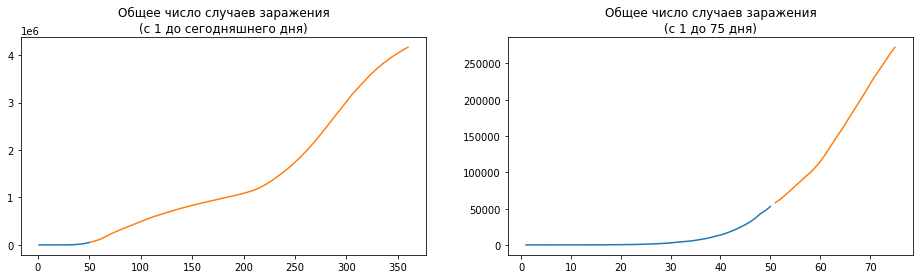

In [273]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].margins(0.05)
ax[0].plot(df_train.day, df_train.total_cases, label="Данные обучающей выборки")
ax[0].plot(df_test.day, df_test.total_cases, label="Данные тестовой выборки")
ax[0].set_title("Общее число случаев заражения\n(с 1 до сегодняшнего дня)")

ax[1].margins(0.05)
ax[1].plot(df_train.day, df_train.total_cases, label="Данные обучающей выборки")
ax[1].plot(df_test.day[:25], df_test.total_cases[:25], label="Данные тестовой выборки")
ax[1].set_title("Общее число случаев заражения\n(с 1 до 75 дня)")

plt.show();

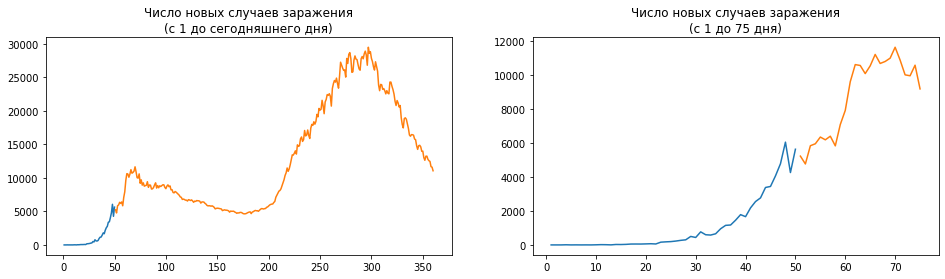

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].margins(0.05)
ax[0].plot(df_train.day, df_train.new_cases, label="Данные обучающей выборки")
ax[0].plot(df_test.day, df_test.new_cases, label="Данные тестовой выборки")
ax[0].set_title("Число новых случаев заражения\n(с 1 до сегодняшнего дня)")

ax[1].margins(0.05)
ax[1].plot(df_train.day, df_train.new_cases, label="Данные обучающей выборки")
ax[1].plot(df_test.day[:25], df_test.new_cases[:25], label="Данные тестовой выборки")
ax[1].set_title("Число новых случаев заражения\n(с 1 до 75 дня)")

plt.show();

Выделим из наших данных X_train, X_test, y_train, y_test.

In [275]:
X_train = df_train.day.values
X_test = df_test.day.values

In [276]:
y_train_new_cases = np.array(df_train.new_cases)
y_test_new_cases = np.array(df_test.new_cases)
y_train_total_cases = np.array(df_train.total_cases)
y_test_total_cases = np.array(df_test.total_cases)
y_train_log_total_cases = np.array(df_train.total_cases_log)
y_test_log_total_cases = np.array(df_test.total_cases_log)

### 2.a Построим модель линейной регрессии на основании столбца "total_cases_log"

Построим модель линейной регрессии

In [277]:
model = LinearRegression()
model.fit(X_train.reshape(-1, 1), y_train_log_total_cases)
alpha = model.coef_[0]
beta = model.intercept_
print(f"Alpha = {alpha}, Beta = {beta}")

Alpha = 0.19829091233588567, Beta = 1.62244623644881


In [278]:
y_pred = model.predict(df_rus.day.values.reshape(-1, 1))
df_rus["prediced_log_total_cases"] = np.array(y_pred)

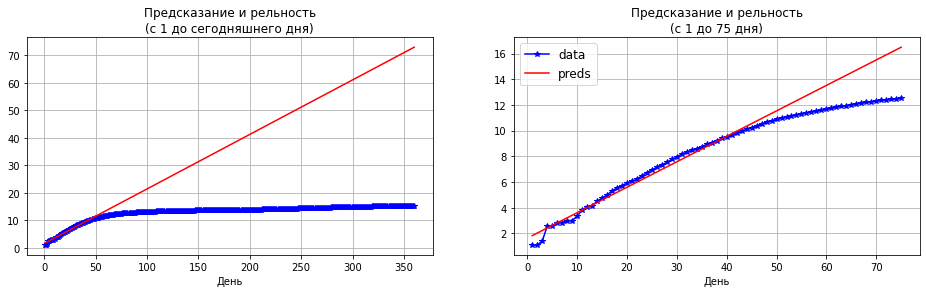

In [279]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(df_rus.day,
           df_rus.total_cases_log,
           color='blue',
           marker='*',
           label='data')
ax[0].plot(df_rus.day,
           df_rus.prediced_log_total_cases,
           color='red',
           label='preds')
ax[0].set(xlabel='День', title='')
ax[0].set_title("Предсказание и рельность\n(с 1 до сегодняшнего дня)")
ax[0].grid()

ax[1].plot(df_rus[:75].day,
           df_rus[:75].total_cases_log,
           color='blue',
           marker='*',
           label='data')
ax[1].plot(df_rus[:75].day,
           df_rus[:75].prediced_log_total_cases,
           color='red',
           label='preds')
ax[1].set(xlabel='День', title='')
ax[1].set_title("Предсказание и рельность\n(с 1 до 75 дня)")
ax[1].grid()

plt.legend(fontsize='large')
plt.show();

Переведем данные от логарифмической шкалы к обычному виду

In [280]:
y_pred_exp = np.exp(y_pred)
df_rus["prediced_total_cases"] = np.array(y_pred_exp)

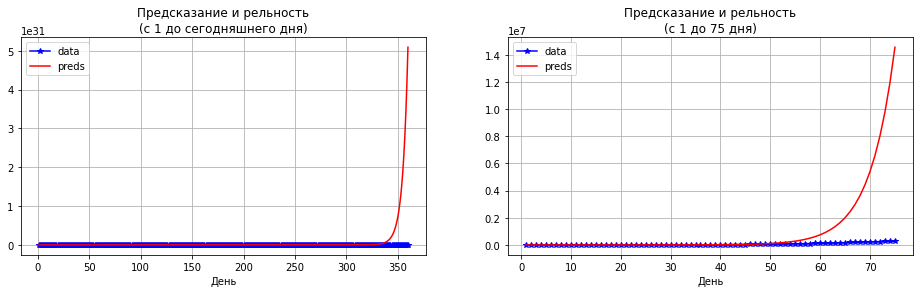

In [281]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(df_rus.day,
           df_rus.total_cases,
           color="blue",
           marker="*",
           label="data")
ax[0].plot(df_rus.day,
           df_rus.prediced_total_cases,
           color="red",
           label="preds")
ax[0].set(xlabel="День", title="Предсказание и рельность\n(с 1 до сегодняшнего дня)")
ax[0].grid()
ax[0].legend()

ax[1].plot(df_rus[:75].day,
           df_rus[:75].total_cases,
           color="blue",
           marker="*",
           label="data")
ax[1].plot(df_rus[:75].day,
           df_rus[:75].prediced_total_cases,
           color="red",
           label="preds")
ax[1].set(xlabel="День", title="Предсказание и рельность\n(с 1 до 75 дня)")
ax[1].grid()
ax[1].legend()

plt.show();

Повторим тот же эксперимент для самописной модели регрессии. Для этого создадим класс модели линейной регрессии

In [282]:
class RegMod():
    
    def __init__(self, mu: np.ndarray, sigma: np.ndarray):
        self.init_mu = mu
        self.init_sigma = sigma
        
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.hstack((np.ones((len(X), 1)), X))
        # Calculate Moore-Penrose pseudoinverse matix
        moore_penrose_p_i = np.linalg.inv(X.T @ X) @ X.T
        # Calculate the weights...
        w = moore_penrose_p_i @ y
        y_pred = X @ w
        # ... and find the variance
        noise_var = (y - y_pred).var()
        alpha = 1 / noise_var
        # Update distribution parameters
        self.sigma = np.linalg.inv(np.linalg.inv(self.init_sigma) + X.T @ X / noise_var)
        self.mu = self.sigma @ (np.linalg.inv(self.init_sigma) @ self.init_mu + X.T @ y / noise_var)
        
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.hstack((np.ones((len(X), 1)), X))
        return X @ self.mu
    
    
    def predict_samples(self, X: np.ndarray, n_samples: int) -> np.ndarray:
        X = np.hstack((np.ones((len(X), 1)), X))
        Ws = np.random.multivariate_normal(self.mu, self.sigma, n_samples)
        res = np.zeros((len(Ws), len(X)))
        for i, w in enumerate(Ws):
            res[i] = X @ w  
        return res

Создадим модель линейной регрессии на основе нашего класса, обучим ее и визуализируем полученный результат

In [283]:
model = RegMod(mu = np.zeros(2), sigma = 20 * np.eye(2))
model.fit(X_train.reshape(-1, 1), np.log(y_train_total_cases))

y_pred_vis_s = model.predict(df_rus.day.values.reshape(-1, 1))

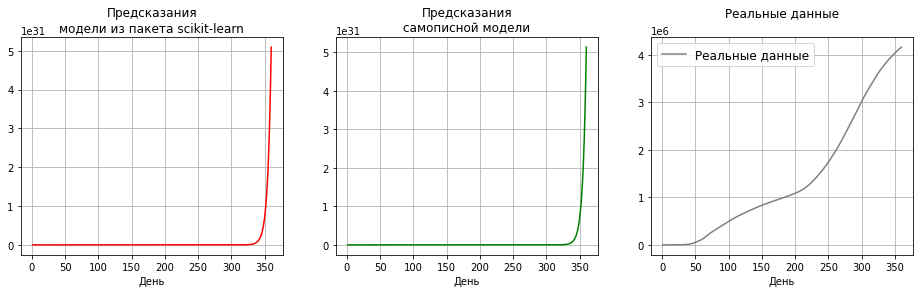

In [284]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(df_rus.day,
           df_rus.prediced_total_cases,
           color="red",
           label="Модель из пакета scikit-learn")
ax[0].set(xlabel="День", title="Предсказания\nмодели из пакета scikit-learn")
ax[0].grid()

ax[1].plot(df_rus.day,
           np.exp(y_pred_vis_s),
           color="green",
           label="Предсказания самописной модели")
ax[1].set(xlabel="День", title="Предсказания\nсамописной модели")
ax[1].grid()

ax[2].plot(df_rus.day,
           df_rus.total_cases,
           color="gray",
           label="Реальные данные")
ax[2].set(xlabel="День", title="Реальные данные\n")
ax[2].grid()

plt.legend(fontsize='large')
plt.show()

Результаты работы обеих моделей идентичны (и отличаются от реальных данных).

### 2.b Найдем апостериорное распределение параметров этой модели для достаточно широкого априорного распределения.

Параметры модели: [1.62163475 0.19831499]


/home/artem/Desktop/ml/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


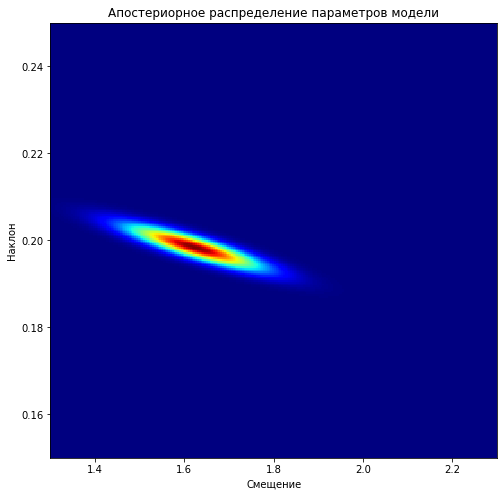

In [307]:
N = 250

plot_lims = (
    (1.3, 2.3),
    (0.15, 0.25)
)

X = np.linspace(*plot_lims[0], N)
Y = np.linspace(*plot_lims[1], N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

print(f"Параметры модели: {model.mu}") 

Z = multivariate_normal.pdf(pos, mean=model.mu, cov=model.sigma)

plt.figure(figsize=(8, 8))
plt.xlim(plot_lims[0])
plt.ylim(plot_lims[1])
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title("Апостериорное распределение параметров модели")
plt.xlabel("Смещение")
plt.ylabel("Наклон")
plt.show();

### 2.c Проведем сэмплирование

In [286]:
date_start = pd.to_datetime("2020-03-03")
date_may = pd.to_datetime("2020-05-01")
date_june = pd.to_datetime("2020-06-01")
date_sept = pd.to_datetime("2020-09-01")

X_may = np.array([[(date_may - date_start).days]])
X_june = np.array([[(date_june - date_start).days]])
X_sept = np.array([[(date_sept - date_start).days]])

y_may_total = int(np.exp(model.predict(X_may)))
y_june_total = int(np.exp(model.predict(X_june)))
y_sept_total = int(np.exp(model.predict(X_sept)))

print(f"К 1 мая: {y_may_total} случаев")
print(f"К 1 июня: {y_june_total} случаев")
print(f"К 1 сентября: {y_sept_total} случаев")

К 1 мая: 610613 случаев
К 1 июня: 285565977 случаев
К 1 сентября: 23955217418346140 случаев


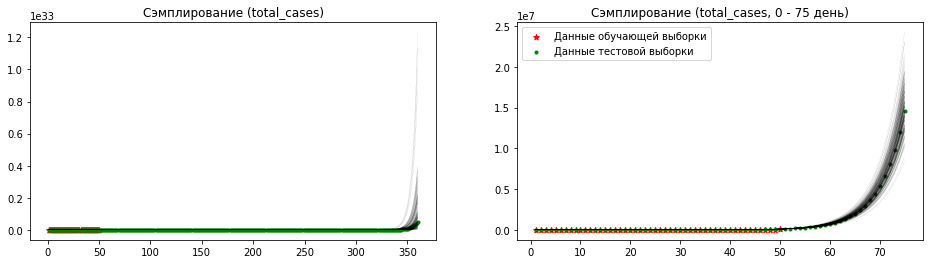

In [288]:
X_sample = np.hstack((X_train, X_test))
y_samples = np.exp(model.predict_samples(X_sample.reshape(-1, 1), 200))

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

for y_sample in y_samples:
    ax[0].plot(X_sample, y_sample, "k-", lw=0.05)
    ax[1].plot(X_sample[:75], y_sample[:75], "k-", lw=0.05)
    
ax[0].scatter(X_train,
              y_train_total_cases,
              label="Данные обучающей выборки",
              marker="*", color="red")
ax[0].scatter(df_rus.day,
              df_rus.prediced_total_cases.values,
              label="Данные тестовой выборки",
              marker=".",
              color="green")
ax[0].set_title('Сэмплирование (total_cases)')
    
ax[1].scatter(X_train,
              y_train_total_cases,
              label="Данные обучающей выборки",
              marker="*",
              color="red")
ax[1].scatter(df_rus.day[:75],
              df_rus.prediced_total_cases.values[:75],
              label="Данные тестовой выборки",
              marker=".",
              color="green")
ax[1].set_title("Сэмплирование (total_cases, 0 - 75 день)")

plt.legend()
plt.show()

Как можно увидеть, прогнозируемое поведение графика предсказанного числа зараженных сильно отличается от реальности (чему в данном случае остается лишь порадоваться.

# Задание 3

### 3.a Будем использовать для предсказания другую модель, основанную на предложенной в работе (Murray, 2020)

Целевая функция остается y_train_log_total_cases, а X_train - все также остается вводом. Уравнение, описывающее зависимость между параметрами модели, при логарифмировании примет вид квадратного уравнения с неизвестными постоянными коэффициентами. Таким образом мы перейдем к следующему:

In [289]:
X_train_new = np.array([np.square(X_train), X_train]).reshape(2, -1).T
X_test_new = np.array([np.square(X_test), X_test]).reshape(2, -1).T

In [290]:
model_sigm = LinearRegression()

In [291]:
model_sigm.fit(X_train_new, y_train_log_total_cases)

LinearRegression()

In [292]:
y_pred_new = model_sigm.predict(np.array([np.square(df_rus.day.values),
                                          df_rus.day.values]).reshape(2, -1).T)
y_pred_new = np.exp(y_pred_new)
y_pred_new_total = y_pred_new.cumsum()

И повторим для самописной модели

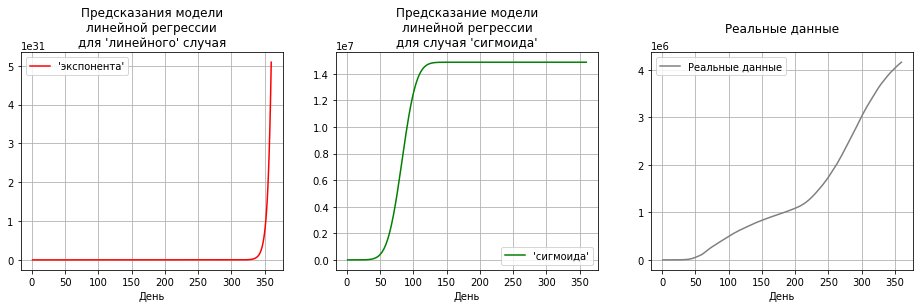

In [293]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(df_rus.day,
           df_rus.prediced_total_cases,
           color="red",
           label="'экспонента'")
ax[0].set(xlabel="День", title="Предсказания модели\nлинейной регрессии\nдля 'линейного' случая")
ax[0].grid()
ax[0].legend()

ax[1].plot(df_rus.day,
           y_pred_new_total,
           color="green",
           label="'сигмоида'")
ax[1].set(xlabel="День", title="Предсказание модели\nлинейной регрессии\nдля случая 'сигмоида'")
ax[1].grid()
ax[1].legend()

ax[2].plot(df_rus.day,
           df_rus.total_cases,
           color="gray",
           label="Реальные данные")
ax[2].set(xlabel="День", title="Реальные данные\n")
ax[2].grid()
ax[2].legend()

plt.show()

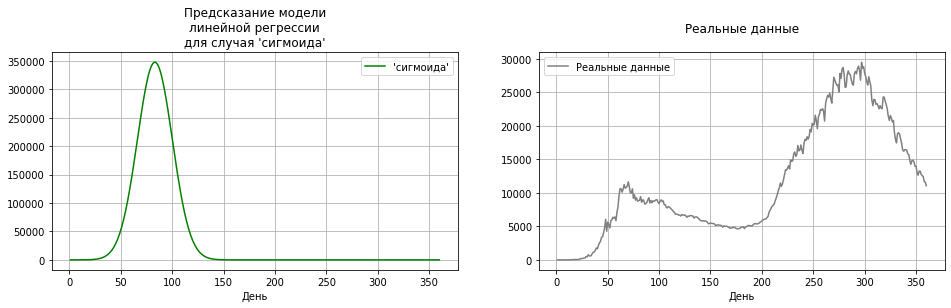

In [294]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(df_rus.day,
           y_pred_new,
           color="green",
           label="'сигмоида'")
ax[0].set(xlabel="День", title="Предсказание модели\nлинейной регрессии\nдля случая 'сигмоида'")
ax[0].grid()
ax[0].legend()

ax[1].plot(df_rus.day,
           df_rus.new_cases,
           color="gray",
           label="Реальные данные")
ax[1].set(xlabel="День", title="Реальные данные\n")
ax[1].grid()
ax[1].legend()

plt.show()

Соберем воедино

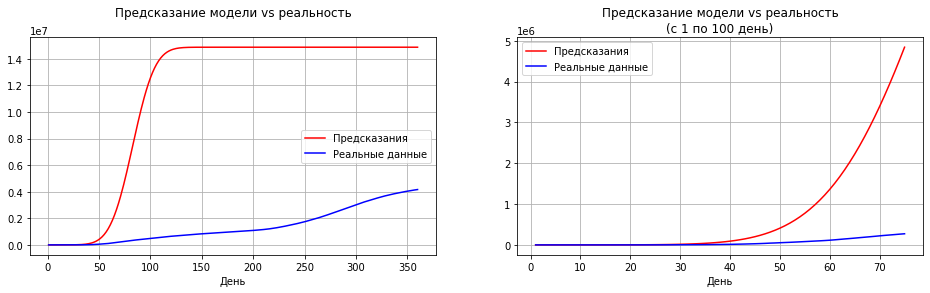

In [295]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(df_rus.day,
           y_pred_new_total,
           color="red",
           label="Предсказания")
ax[0].plot(df_rus.day,
           df_rus.total_cases,
           color="blue",
           label="Реальные данные")
ax[0].set(xlabel="День", title="Предсказание модели vs реальность\n")
ax[0].grid()
ax[0].legend()

ax[1].plot(df_rus[:75].day,
           y_pred_new_total[:75],
           color="red",
           label="Предсказания")
ax[1].plot(df_rus.day[:75],
           df_rus.total_cases[:75],
           color="blue",
           label="Реальные данные")
ax[1].set(xlabel="День", title="Предсказание модели vs реальность\n(с 1 по 100 день)")
ax[1].grid()
ax[1].legend()

plt.show;

### 3.b Повторим поиск апостериорного распределения для новой модели.

In [296]:
a, b, c = *model_sigm.coef_, model_sigm.intercept_

In [300]:
print("Параметы моедли:\n", a, "\n", b, "\n", c)

Параметра моедли:
 -0.001717670504179804 
 0.2858921080490556 
 0.8632358736013375


Параметры модели: [1.62163475 0.19831499]


/home/artem/Desktop/ml/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


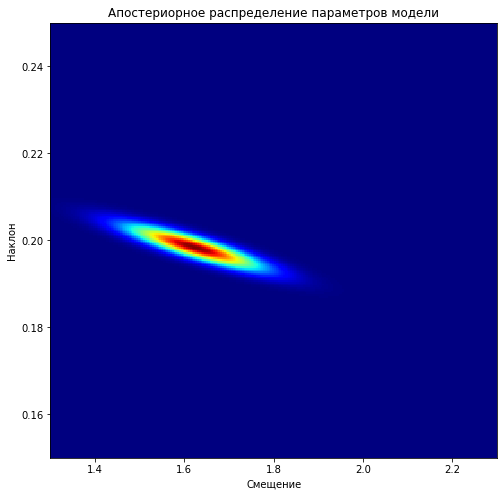

In [297]:
N = 250

plot_lims = (
    (1.3, 2.3),
    (0.15, 0.25)
)

X = np.linspace(*plot_lims[0], N)
Y = np.linspace(*plot_lims[1], N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

print(f"Параметры модели: {model.mu}") 

Z = multivariate_normal.pdf(pos, mean=model.mu, cov=model.sigma)

plt.figure(figsize=(8, 8))
plt.xlim(plot_lims[0])
plt.ylim(plot_lims[1])
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title("Апостериорное распределение параметров модели")
plt.xlabel("Смещение")
plt.ylabel("Наклон")
plt.show();

In [324]:
from scipy.stats import multivariate_normal

# create data
N = 250
xs = np.linspace(0, 60, N)
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
Z = np.linspace(-3, 3, N)
X, Y, Z = np.meshgrid(X, Y, Z)

pos = np.empty(X.shape + (3,))
pos[:, :, :, 0] = X
pos[:, :, :, 1] = Y
pos[:, :, :, 2] = Z

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 2))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
#     plt.scatter([-.5], [.5], marker='*', s=120)
    plt.show()


In [ ]:
cur_mu = np.array([a, b, c])
cur_sigma = 2 * np.eye(3)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)